In [1]:
def clip(tmp1):
    import subprocess
    import shlex  # 导入 shlex 模块
    # 使用 shlex.quote 来转义 inp 字符串
    tmp2 = str(tmp1)
    safe_str = shlex.quote(tmp2)
    subprocess.run('echo {} | wclip'.format(safe_str), shell=True)  

def cvin(k):
    clip(In[k])
    
import numpy as np
import matplotlib.pyplot as plt

import time 
#from tqdm import tqdm  # tqdm是显示循环进度条的库
from tqdm.notebook import tqdm #推荐在jupyter中使用自带的进度条
import copy #复制方法

#-------------------------------------------------------------------
np.random.seed(0) #重置种子为0
np.set_printoptions(precision=3, suppress=True, linewidth=100)#格式化输出
#-------------------------------------------------------------------

import rl_utils
import random
import gymnasium as gym
import collections
import torch
import torch.nn.functional as F
import os

import torch

### 基于值函数&基于策略
本书之前的章节讲解了基于 **值函数的方法（DQN）** 和**基于策略的方法（REINFORCE）**，基于值函数的方法只学习一个价值函数，而基于策略的方法只学习一个策略函数。


## Actor-Critic
Actor-Critic：既学习价值函数，又学习策略函数——本质上是基于策略的算法，因为这一系列算法的目标都是优化一个带参数的策略，只是会额外学习价值函数。

### 策略梯度--更一般形式
> **易混淆：** 策略梯度不是REINFORCE的形式，而是说，REINFOCE算法用蒙特卡洛方法来估计Q(s,a)，准确说在**策略梯度**中，可以把梯度写成下面这个更加一般的形式：
$$
g=\mathbb{E}\left[\sum_{t=0}^{T} \psi_{t} \nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right)\right]
$$

其中$\psi_{t}$可以有很多种形式:
1. $\sum_{t^{\prime}=0}^{T} \gamma^{t^{\prime}} r_{t^{\prime}}$ : 轨迹的总回报;
2. $\sum_{t^{\prime}=t}^{T} \gamma^{t^{\prime}-t} r_{t^{\prime}}$ : 动作 $a_{t}$ 之后的回报;
3. $\sum_{t^{\prime}=t}^{T} \gamma^{t^{\prime}-t} r_{t^{\prime}}-b\left(s_{t}\right)$ : 基准线版本的改进;
4. $Q^{\pi_{\theta}}\left(s_{t}, a_{t}\right)$ : 动作价值函数;
5. $A^{\pi_{\theta}}\left(s_{t}, a_{t}\right)$ : 优势函数;
6. $r_{t}+\gamma V^{\pi_{\theta}}\left(s_{t+1}\right)-V^{\pi_{\theta}}\left(s_{t}\right)$ : 时序差分残差

- 在之前的蒙特卡洛近似估计Q(s,a)带来的问题是方差过大，为此引入了**基线函数(baseline function)** 即$b\left(s_{t}\right)$来减小方差。
- 如果不用蒙特卡洛近似，直接估计4.Q(s,a)，也存在方差过大的问题，为此引入了： **优势函数(advantage function)** ，这就是形式5
- 如果用V来得到Q，就是公式$Q^{\pi}(s, a)=r(s, a)+\gamma \sum_{s^{\prime} \in S} P\left(s^{\prime} \mid s, a\right) V^{\pi}\left(s^{\prime}\right)$，将该公式简写，就得到了**形式6:$Q=r+\gamma V$**

这是一个很核心的理念：

**_——减去平均值取"偏差"，比如Dueling DQN的VA减去 $\frac{1}{|\mathcal{A}|} \sum_{a^{\prime}} A_{\eta, \beta}(s, a^{\prime})$ _**

> 除此之外，REINFORCE 算法基于蒙特卡洛采样，只能在序列结束后进行更新，这同时也要求任务具有有限的步数——而 Actor-Critic 算法则可以在每一步之后都进行更新，并且不对任务的步数做限制

### Actor-Critic算法
Actor-Critic的核心就是公式(6)，即为**时序差分残差** $\psi_{t}=r_{t}+\gamma V^{\pi}\left(s_{t+1}\right)-V^{\pi}\left(s_{t}\right)$来指导策略梯度

将 Actor-Critic 分为两个部分：Actor（策略网络）和 Critic（价值网络）:
- Actor与环境交互，并在Critic**价值函数**的指导下用**策略梯度**学习一个更好的_策略_。
- Critic通过Actor环境交互收集的数据学习一个**价值函数**，这个价值函数会用于**判断**在当前状态什么动作是好的，什么动作不是好的，进而帮助Actor进行策略更新。

#### Actor--策略梯度(蒙特卡洛?)：
将其中$\nabla_{\theta}$更换为时序差分残差$\psi_{t}=r_{t}+\gamma V^{\pi}\left(s_{t+1}\right)-V^{\pi}\left(s_{t}\right)$
$$
\nabla_{\theta} J(\theta)=\mathbb{E}_{\pi_{\theta}}\left[\left\{r_{t}+\gamma V^{\pi}\left(s_{t+1}\right)-V^{\pi}\left(s_{t}\right)\right\}\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right)\right]
$$
#### Critic--价值函数(时序差分残差)：
将 Critic 价值网络表示为$V_\omega$，参数为$\omega$。于是，我们可以采取时序差分残差的学习方式，对于单个数据定义如下价值函数的损失函数：
$$
\mathcal{L}(\omega)=\frac{1}{2}\left(r+\gamma V_{\omega}\left(s_{t+1}\right)-V_{\omega}\left(s_{t}\right)\right)^{2}
$$
计算方法：与 DQN 中一样，我们采取类似于目标网络的方法，将上式中$r+\gamma V_{\omega}\left(s_{t+1}\right)$作为时序差分目标，不会产生梯度来更新价值函数，因此最终的梯度计算公式为：
$$
\nabla_{\omega} \mathcal{L}(\omega)=-\left(r+\gamma V_{\omega}\left(s_{t+1}\right)-V_{\omega}\left(s_{t}\right)\right) \nabla_{\omega} V_{\omega}\left(s_{t}\right)
$$
> 但在实际使用中，我们不会直接算$\nabla_{\omega} \mathcal{L}(\omega)$，而是使用 **F.mse_loss($r_{t}+\gamma V^{\pi}\left(s_{t+1}\right),V^{\pi}\left(s_{t}\right)$)** 功能自动计算均方差即可

### Actor-Critic具体流程如下：
- 初始化策略网络参数 \theta ，价值网络参数 \omega
- **for** 序列 $e=1 \rightarrow E$ **do :**
- ----用当前策略 $\pi_{\theta}$ 采样轨迹 $\left\{s_{1}, a_{1}, r_{1}, s_{2}, a_{2}, r_{2}, \ldots\right\}$
- ----为每一步数据计算: $\delta_{t}=r_{t}+\gamma V_{\omega}\left(s_{t+1}\right)-V_{\omega}\left(s_{t}\right)$
- ----更新价值参数 $w=w+\alpha_{\omega} \sum_{t} \delta_{t} \nabla_{\omega} V_{\omega}\left(s_{t}\right)$
- ----更新策略参数 $\theta=\theta+\alpha_{\theta} \sum_{t} \delta_{t} \nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right)$
- **end for**

### 策略网络

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)  # 输出每个动作对应的概率

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

### 价值网络

In [3]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1) # 输出状态对应的价值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### A2C算法

### |为什么在ActorCritic中，不使用target_critic_net?
在强化学习的 Actor-Critic 方法中，引入 Target Network 主要是为了解决 Q-learning 方法中的不稳定性和发散问题，然而，在 Actor-Critic 方法中，这种不稳定性问题相对较小：

因为我们有一个明确的 Critic 网络来估计状态的价值或动作的 Q 值，而 Actor 只负责策略。由于 Actor 和 Critic 是分开的，并且每次更新都基于真实的奖励和 Critic 的估计，这使得学习过程相对更稳定。

In [4]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        probs = self.actor(state.unsqueeze(0))
        action_dist = torch.distributions.Categorical(probs)  # 根据给定概率创建一个分类的分布
        action = action_dist.sample()  # 从分布中采样一个类别，这里是动作
        return action.item()  # 取到的动作序号是tensor, 转成普通python数字

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), 
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), 
                               dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), 
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), 
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), 
                             dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(np.array(transition_dict['truncated']), 
                                 dtype=torch.int).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差, 实际上就是优势函数A
        log_probs = torch.log(self.actor(states).gather(1, actions))
        # 评论员/价值网络均方误差损失函数, td_target仅作为标量
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))  
        
        # 演员/策略网络误差, td_delta是从td_target来的, 因此也.detach(), 仅作为标量
        actor_loss = torch.mean(-log_probs * td_delta.detach())  
        
        self.critic_optimizer.zero_grad()
        self.actor_optimizer.zero_grad()
        critic_loss.backward()  # 计算价值网络的梯度
        actor_loss.backward()  # 计算策略网络的梯度
        self.critic_optimizer.step()  # 更新价值网络的参数
        self.actor_optimizer.step()  # 更新策略网络的参数


$$
\nabla_{\theta} J(\theta)=\mathbb{E}_{\pi_{\theta}}\left[\left\{r_{t}+\gamma V^{\pi}\left(s_{t+1}\right)-V^{\pi}\left(s_{t}\right)\right\}\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right)\right]
$$
$$
\mathcal{L}(\omega)=\frac{1}{2}\left(r+\gamma V_{\omega}\left(s_{t+1}\right)-V_{\omega}\left(s_{t}\right)\right)^{2}
$$
$$
\nabla_{\omega} \mathcal{L}(\omega)=-\left(r+\gamma V_{\omega}\left(s_{t+1}\right)-V_{\omega}\left(s_{t}\right)\right) \nabla_{\omega} V_{\omega}\left(s_{t}\right)
$$
> 但在实际使用中，我们不会直接算$\nabla_{\omega} \mathcal{L}(\omega)$，而是使用 **F.mse_loss($r_{t}+\gamma V^{\pi}\left(s_{t+1}\right),V^{\pi}\left(s_{t}\right)$)** 功能自动计算均方差即可

#### |.detach()分离梯度计算：
 `.detach() `确保 td_target 在计算梯度时被视为常数，因此不会为它计算梯度：
 > 在计算 actor_loss 时，我们使用 td_delta.detach()，这是因为在 Actor 的更新中，我们只关心如何优化策略，而不关心优势函数$A(s_t,a_t)$ 的具体计算方式。因此，我们将其从计算图中分离，确保 actor_loss.backward() 只计算 Actor 网络的梯度，而不会计算 Critic 网络的梯度。
 
 当我们考虑 `critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))` 时，使用和不使用 `.detach()` 对损失计算和后续的反向传播有明显的影响。

1. **使用 `.detach()`**:

   - **损失计算**: 使用 `.detach()` 意味着 `td_target` 被视为一个常数，所以损失函数仅考虑 Critic 网络的输出 `self.critic(states)` 与这个常数之间的差异。
   - **反向传播**: 当我们对损失进行反向传播时，只会计算与 `self.critic(states)` 相关的梯度。换句话说，我们只关心如何更好地调整 Critic 的参数使其输出更接近这个固定的 `td_target`。`td_target` 本身不会有任何梯度，因为它已经从计算图中分离出来。

2. **不使用 `.detach()`**:

   - **损失计算**: 不使用 `.detach()` 时，`td_target` 仍然是一个计算图的一部分。损失函数仍然计算 Critic 的输出与 `td_target` 之间的差异，但现在 `td_target` 不再是常数，而是依赖于网络的其他部分。
   - **反向传播**: 当我们对损失进行反向传播时，不仅会计算与 `self.critic(states)` 相关的梯度，还会计算与 `td_target` 相关的梯度。这意味着，我们不仅关心如何调整 Critic 的参数使其输出更接近 `td_target`，还关心如何更好地计算 `td_target` 本身。 **这可能会导致不稳定的训练，因为您现在正在试图优化两个相互依赖的部分。**
   
> **_总结：如果不想被反向传播影响，还有一种方法是使用target_net目标网络_**


#### |torch.mean是否需要添加？
这两个加和不加torch.mean有什么区别:
```python
actor_loss = -torch.mean(log_probs * td_delta.detach())
critic_loss = torch.mean(F.mse_loss(td_target.detach(),self.critic(states)))
```
通常情况下，使用平均损失可以使得训练过程更加稳定，因为损失和梯度的尺度不会随着批次大小的变化而变化。
- 计算所有样本的平均损失，这意味着无论批次大小是多少，损失的尺度始终保持相对一致。
- 如果不使用 torch.mean，损失将会是所有样本损失的总和。这可能导致损失的尺度随着批次大小的变化而变化，进而影响梯度的大小。这可能会要求您调整学习率或其他超参数以适应不同的批次大小

### ✅怎么理解A2C
优势函数的思想在 Dueling DQN 中已经提到过了，那里需要 Q 值，所以把 $A = Q - V​​$ 变成 $Q=V+A$，其中 A 也是由 Q 网络的一部分估计的，这里是改进的优势函数，需要的就是 $A = Q - V​​$，其中 Q 来自演员网络，V 来自评论员网络。

目标函数就是动作的概率乘以优势函数 A，即 $log\_prob(action)* A$，**推导待补充**，优势函数原本是每轮以及后续获得的折算奖励（G）减去一个基线 b，也就是 $A = G-b$，但是这个折算是比较麻烦的，因为有 $E(G) = Q_{\pi_{\theta}}(s^n_t,a^n_t)$，所以可以考虑用 Q 替代 G，而 $b$ 一般是状态价值函数 $V_{\pi_{\theta}}(s_t)$，因此优势函数变成
$$
A = Q_{\pi_{\theta}}(s^n_t,a^n_t)-V_{\pi_{\theta}}(s_t)
$$
可以用 V 来估计 Q，即有 $Q_{\pi}(s^n_t,a^n_t)=E(r_t^n+V_{\pi_{\theta}}(s_{t+1}))$ ，把这个式子带入上式，并且这里先去掉期望，所以有
$$
A^{\theta}\left(s_t,a_t\right) = r_t^n+V_{\pi}(s_{t+1}^n) - V_{\pi}(s_t)
$$
期望值很难算，经过多次实验，去掉期望值容易计算，并且效果还可以，因此在这里一般就去掉期望，带入最开始给的优势函数。

这样是很容易代码实现的。在代码里面，优势 G 就是 `td_delta`，再乘以负的动作概率的对数，就等于演员网络的损失，对其参数求梯度，就实现梯度上升

### 参数初始化

In [5]:
# A2C相关
actor_lr = 1e-3
critic_lr = 1e-2
total_epochs = 20
total_episodes = 100
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device: ', device)

# 环境相关
env_name = 'CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)

# 神经网络相关
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n

agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

device:  cuda


### 读取检查点

In [6]:
def read_ckp(CKP_PATH):
    if os.path.exists(CKP_PATH):
        checkpoint = torch.load(CKP_PATH)
        return {
            'epoch': checkpoint.get('epoch', 0), #强行多轮训练
            'episode': checkpoint.get('episode', 0),
            'epsilon': checkpoint.get('epsilon', 1),
            'actor_best_weight': checkpoint.get('actor_best_weight', None),
            'critic_best_weight': checkpoint.get('critic_best_weight', None),
            'return_list': checkpoint.get('return_list', [])
        }
    else:
        # 创建路径所需的文件夹
        os.makedirs(os.path.dirname(CKP_PATH), exist_ok=True)
        return {
            'epoch': 0,
            'episode': 0,
            'epsilon': 1,
            'actor_best_weight': None,
            'critic_best_weight': None,
            'return_list': []
        }

def save_ckp(data, PATH):
    os.makedirs(os.path.dirname(PATH), exist_ok=True)  # 确保路径存在
    torch.save(data, PATH)

In [7]:
CKP_PATH = 'tmp/9_v2_Actor-Critic.pt'
checkpoint_data = read_ckp(CKP_PATH)

s_epoch = checkpoint_data['epoch']
s_episode = checkpoint_data['episode']
epsilon = checkpoint_data['epsilon']
actor_best_weight = checkpoint_data['actor_best_weight']
critic_best_weight = checkpoint_data['critic_best_weight']
return_list = checkpoint_data['return_list']

if actor_best_weight is not None and critic_best_weight is not None:
        agent.actor.load_state_dict(actor_best_weight)
        agent.critic.load_state_dict(critic_best_weight)

###  训练

<1/20>:   0%|          | 0/100 [00:00<?, ?it/s]

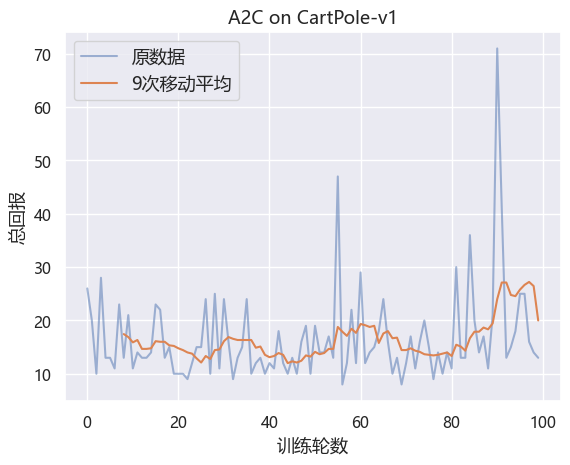

<2/20>:   0%|          | 0/100 [00:00<?, ?it/s]

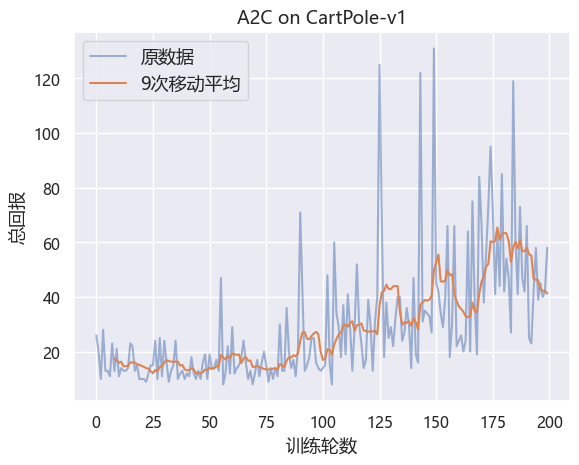

<3/20>:   0%|          | 0/100 [00:00<?, ?it/s]

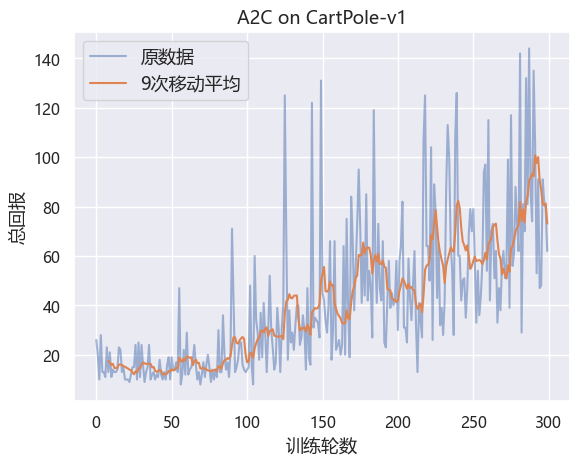

<4/20>:   0%|          | 0/100 [00:00<?, ?it/s]

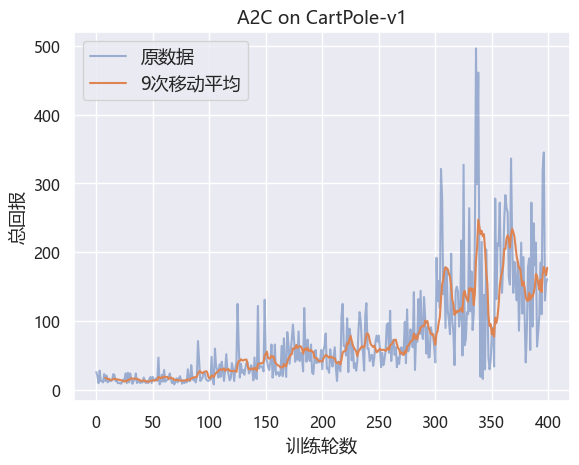

<5/20>:   0%|          | 0/100 [00:00<?, ?it/s]

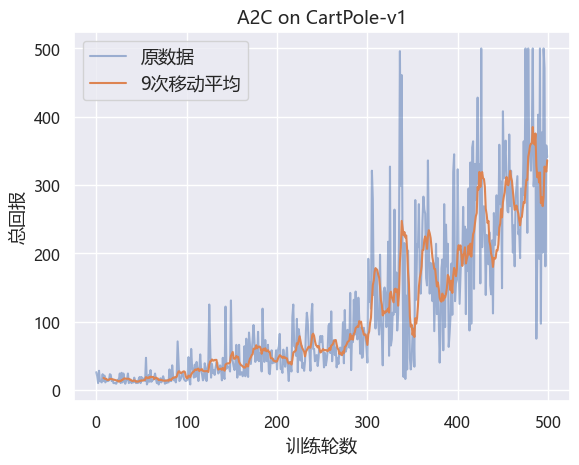

<6/20>:   0%|          | 0/100 [00:00<?, ?it/s]

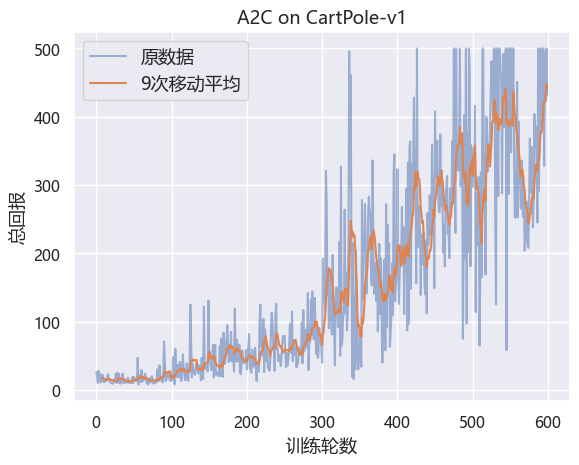

<7/20>:   0%|          | 0/100 [00:00<?, ?it/s]

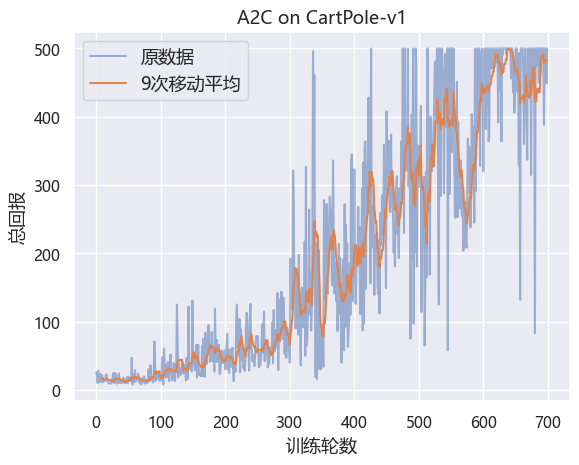

<8/20>:   0%|          | 0/100 [00:00<?, ?it/s]

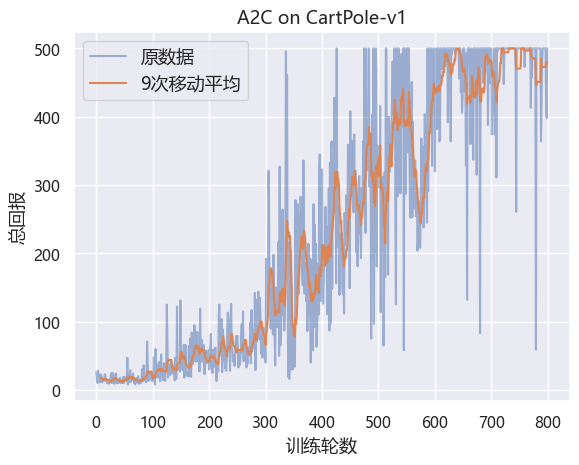

<9/20>:   0%|          | 0/100 [00:00<?, ?it/s]

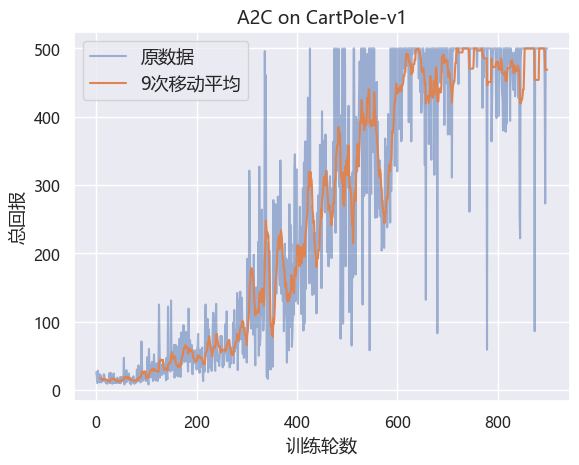

<10/20>:   0%|          | 0/100 [00:00<?, ?it/s]

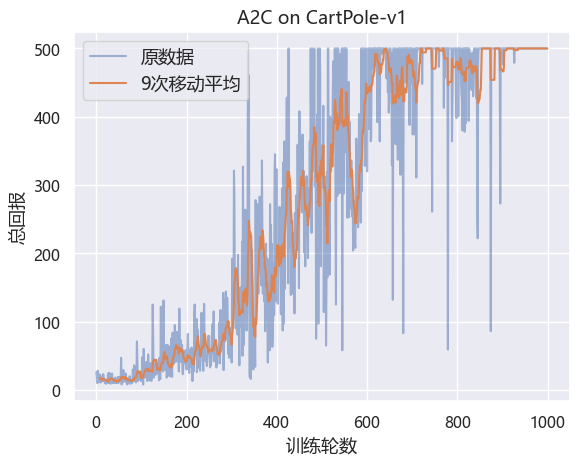

<11/20>:   0%|          | 0/100 [00:00<?, ?it/s]

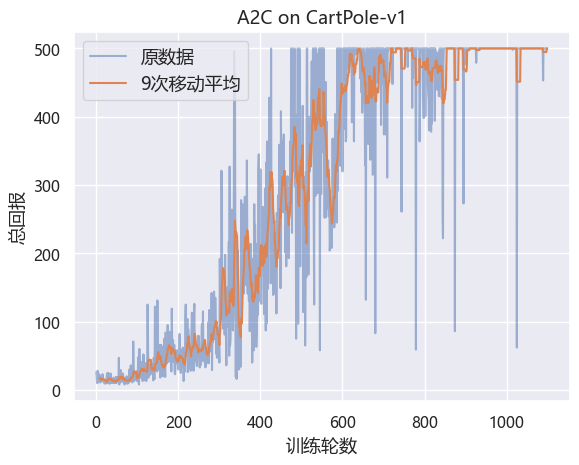

<12/20>:   0%|          | 0/100 [00:00<?, ?it/s]

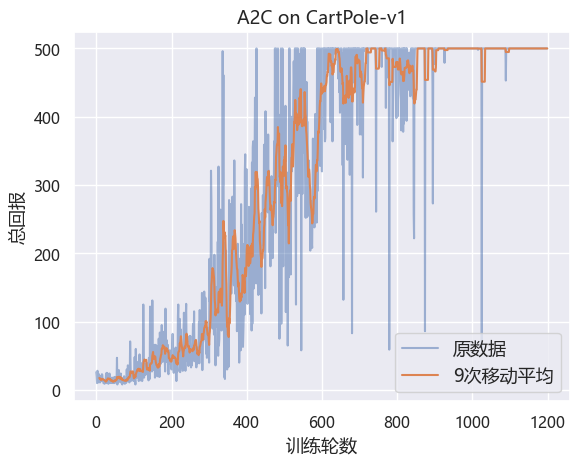

<13/20>:   0%|          | 0/100 [00:00<?, ?it/s]

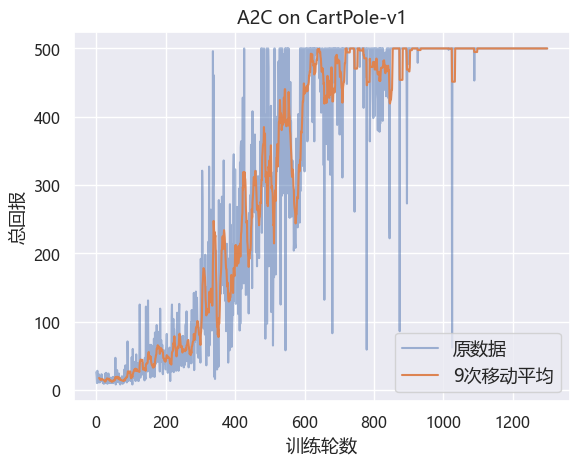

<14/20>:   0%|          | 0/100 [00:00<?, ?it/s]

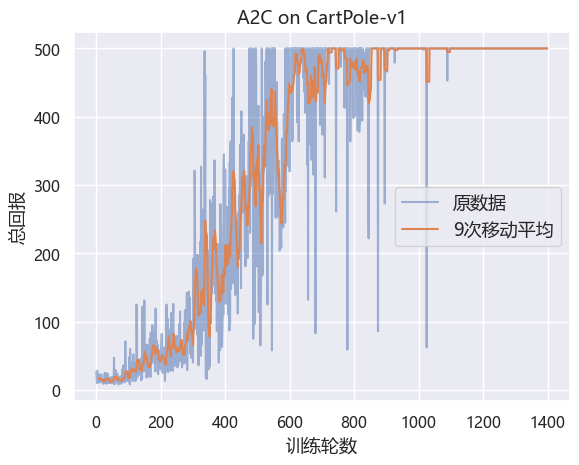

<15/20>:   0%|          | 0/100 [00:00<?, ?it/s]

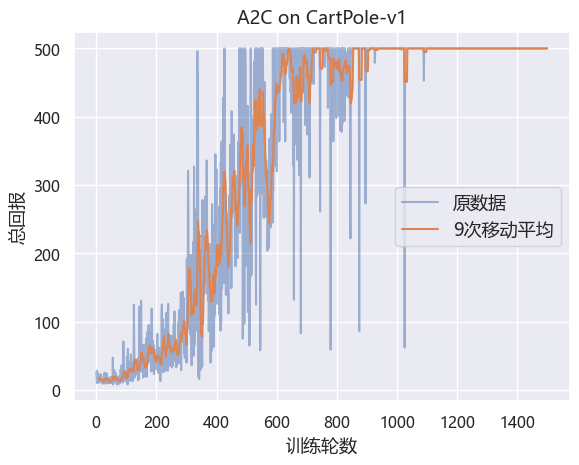

<16/20>:   0%|          | 0/100 [00:00<?, ?it/s]

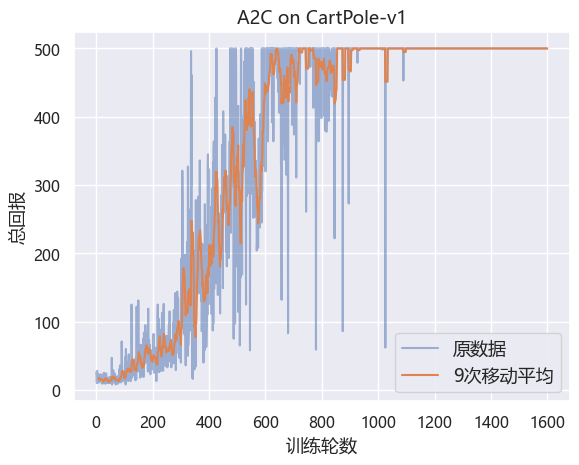

<17/20>:   0%|          | 0/100 [00:00<?, ?it/s]

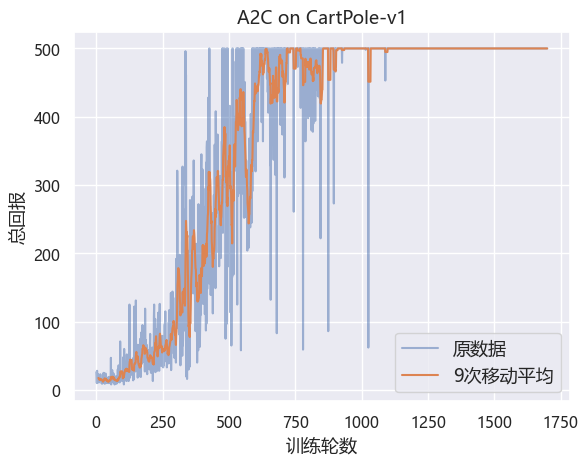

<18/20>:   0%|          | 0/100 [00:00<?, ?it/s]

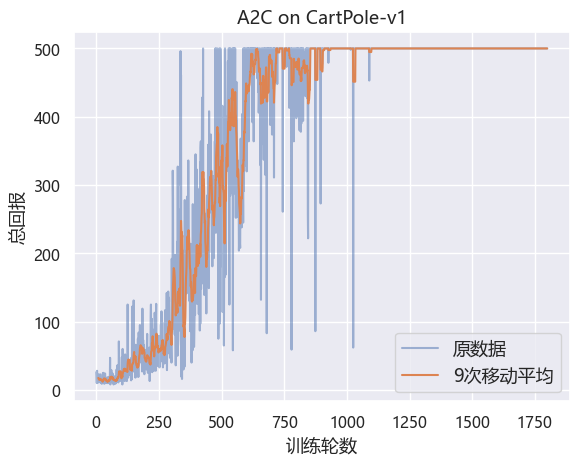

<19/20>:   0%|          | 0/100 [00:00<?, ?it/s]

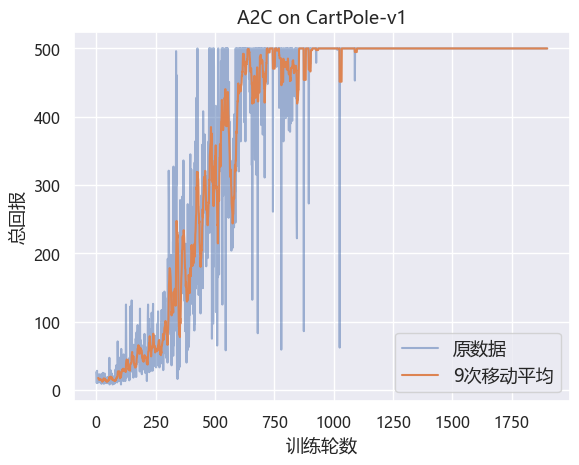

<20/20>:   0%|          | 0/100 [00:00<?, ?it/s]

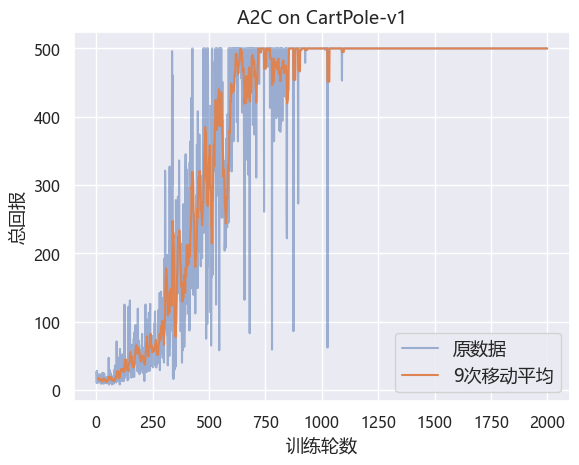

总耗时: 30分钟


[26.0,
 20.0,
 10.0,
 28.0,
 13.0,
 13.0,
 11.0,
 23.0,
 13.0,
 21.0,
 11.0,
 14.0,
 13.0,
 13.0,
 14.0,
 23.0,
 22.0,
 13.0,
 15.0,
 10.0,
 10.0,
 10.0,
 9.0,
 12.0,
 15.0,
 15.0,
 24.0,
 10.0,
 25.0,
 11.0,
 24.0,
 16.0,
 9.0,
 13.0,
 15.0,
 24.0,
 10.0,
 12.0,
 13.0,
 10.0,
 12.0,
 11.0,
 18.0,
 12.0,
 10.0,
 13.0,
 10.0,
 16.0,
 19.0,
 10.0,
 19.0,
 14.0,
 14.0,
 17.0,
 13.0,
 47.0,
 8.0,
 12.0,
 22.0,
 12.0,
 29.0,
 12.0,
 14.0,
 15.0,
 18.0,
 24.0,
 16.0,
 10.0,
 13.0,
 8.0,
 12.0,
 17.0,
 11.0,
 16.0,
 20.0,
 15.0,
 9.0,
 14.0,
 10.0,
 14.0,
 11.0,
 30.0,
 13.0,
 13.0,
 36.0,
 20.0,
 14.0,
 17.0,
 11.0,
 21.0,
 71.0,
 41.0,
 13.0,
 15.0,
 18.0,
 25.0,
 25.0,
 16.0,
 14.0,
 13.0,
 14.0,
 15.0,
 48.0,
 16.0,
 8.0,
 60.0,
 34.0,
 29.0,
 18.0,
 37.0,
 19.0,
 41.0,
 29.0,
 13.0,
 29.0,
 52.0,
 30.0,
 23.0,
 14.0,
 17.0,
 39.0,
 30.0,
 13.0,
 31.0,
 40.0,
 125.0,
 67.0,
 18.0,
 38.0,
 25.0,
 29.0,
 22.0,
 32.0,
 40.0,
 40.0,
 24.0,
 27.0,
 36.0,
 30.0,
 14.0,
 47.0,
 19.0,
 16.0,
 122

In [8]:
rl_utils.train_on_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, return_list, CKP_PATH)        

根据实验结果我们可以发现，Actor-Critic 算法很快便能收敛到最优策略，并且训练过程非常稳定，抖动情况相比 REINFORCE 算法有了明显的改进，这说明价值函数的引入减小了方差。

## 总结
本章讲解了 Actor-Critic 算法，它是基于值函数的方法和基于策略的方法的叠加。价值模块 Critic 在策略模块 Actor 采样的数据中学习分辨什么是好的动作，什么不是好的动作，进而指导 Actor 进行策略更新。随着 Actor 的训练的进行，其与环境交互所产生的数据分布也发生改变，这需要 Critic 尽快适应新的数据分布并给出好的判别。

Actor-Critic 算法非常实用，后续章节中的 TRPO、PPO、DDPG、SAC 等深度强化学习算法都是在 Actor-Critic 框架下进行发展的。深入了解 Actor-Critic 算法对读懂目前深度强化学习的研究热点大有裨益。

### 作图

In [9]:
rl_utils.picture_return(return_list, 'A2C', env_name, 9)

TypeError: no numeric data to plot

### 连续动作
[可能要跑10万轮才能稳定收敛](https://medium.com/deeplearningmadeeasy/advantage-actor-critic-continuous-case-implementation-f55ce5da6b4c)

In [ ]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        # 也可以直接用tanh激活输出一个固定值, 再缩放为所需动作值
        # 输出均值方差的好处是可以创建一个正态分布, 再采采样一次, 还有探索空间
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))  # 最大动作值是2, 因此乘以2缩放
        std = F.softplus(self.fc_std(x))
        return mu, std

In [ ]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1) # 输出状态对应的价值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)  # 根据给定概率创建一个分类的分布
        action = action_dist.sample()  # 从分布中采样一个类别，这里是动作
        return [action.item()]  # 取到的动作序号是tensor, 转成普通python数字

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), 
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), 
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), 
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), 
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), 
                             dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(np.array(transition_dict['truncated']), 
                                 dtype=torch.int).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        # 评论员/价值网络均方误差损失函数, td_target仅作为标量
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))  
        # 演员/策略网络误差, td_delta是从td_target来的, 因此也.detach(), 仅作为标量
        actor_loss = torch.mean(-log_probs * td_delta.detach())  
        self.critic_optimizer.zero_grad()
        self.actor_optimizer.zero_grad()
        critic_loss.backward()  # 计算价值网络的梯度
        actor_loss.backward()  # 计算策略网络的梯度
        self.critic_optimizer.step()  # 更新价值网络的参数
        self.actor_optimizer.step()  # 更新策略网络的参数

In [ ]:
# A2C相关
actor_lr = 1e-3
critic_lr = 1e-2
total_epochs = 20
total_episodes = 100
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device: ', device)

# 环境相关
env_name = 'Pendulum-v1'
env = gym.make(env_name)
torch.manual_seed(0)

# 神经网络相关
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.shape[0]

agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

In [ ]:
def read_ckp(CKP_PATH):
    if os.path.exists(CKP_PATH):
        checkpoint = torch.load(CKP_PATH)
        return {
            'epoch': checkpoint.get('epoch', 0), #强行多轮训练
            'episode': checkpoint.get('episode', 0),
            'epsilon': checkpoint.get('epsilon', 1),
            'actor_best_weight': checkpoint.get('actor_best_weight', None),
            'critic_best_weight': checkpoint.get('critic_best_weight', None),
            'return_list': checkpoint.get('return_list', [])
        }
    else:
        # 创建路径所需的文件夹
        os.makedirs(os.path.dirname(CKP_PATH), exist_ok=True)
        return {
            'epoch': 0,
            'episode': 0,
            'epsilon': 1,
            'actor_best_weight': None,
            'critic_best_weight': None,
            'return_list': []
        }

def save_ckp(data, PATH):
    os.makedirs(os.path.dirname(PATH), exist_ok=True)  # 确保路径存在
    torch.save(data, PATH)

In [ ]:
CKP_PATH = 'tmp/9_v1_3-Actor-Critic.pt'
checkpoint_data = read_ckp(CKP_PATH)


In [ ]:
checkpoint_data 

In [ ]:
CKP_PATH = 'tmp/9_v1_3-Actor-Critic.pt'
checkpoint_data = read_ckp(CKP_PATH)

s_epoch = checkpoint_data['epoch']
s_episode = checkpoint_data['episode']
epsilon = checkpoint_data['epsilon']
actor_best_weight = checkpoint_data['actor_best_weight']
critic_best_weight = checkpoint_data['critic_best_weight']
return_list = checkpoint_data['return_list']

if actor_best_weight is not None and critic_best_weight is not None:
        agent.actor.load_state_dict(actor_best_weight)
        agent.critic.load_state_dict(critic_best_weight)

CKP_PATH = 'checkpoints/A2C_PDv1.pt'
s_epoch, s_episode, return_list = read_ckp(CKP_PATH)

### 训练

In [ ]:
return_list = rl_utils.train_on_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, return_list, CKP_PATH)

### 作图

In [ ]:
rl_utils.picture_return(return_list, 'A2C', env_name)

In [ ]:
rl_utils.show_gym_policy(env_name, agent, if_return=True)

## 附录：

### |"目标网络"不会产生梯度来更新价值函数？
意思是说，目标网络是主网络的一个冻结的复制品，它的权重不会经常更新，
说“不会产生梯度来更新价值函数”时，

意思是当我们计算损失函数并进行反向传播时，使用目标网络计算的部分（在这种情况下是$r+\gamma V_{\omega}\left(s_{t+1}\right)$）不会参与梯度的计算。

换句话说，我们不会计算这部分相对于网络权重的梯度，因为这部分的权重是固定的（不会被更新）

### |$\nabla_{\omega} \mathcal{L}(\omega)$如何得出？
这个1/2在之前"DQN|为何均方误差 (MSE)损失函数使用1/2公式"解释过，其实就是链式求偏导比较方便，具体计算过程就一个换元+链式：
$$
\mathcal{L}(\omega)=\frac{1}{2}\left(r+\gamma V_{\omega}\left(s_{t+1}\right)-V_{\omega}\left(s_{t}\right)\right)^{2}
$$
1. 首先，我们考虑损失函数 $\mathcal{L}(\omega)$是如何依赖于$ V_\omega(s_t) $和$V_\omega(s_{t+1})$的。具体来说，损失函数通过$\Delta V$依赖于这两个值。
2. 因此，我们可以使用链式法则来分别计算损失函数关于$V_\omega(s_t)$和$V_\omega(s_{t+1})$的梯度：
$$
\frac{\partial \mathcal{L}(\omega)}{\partial \omega} = \frac{\partial \mathcal{L}(\omega)}{\partial V_\omega(s_t)} \times \frac{\partial V_\omega(s_t)}{\partial \omega} + \frac{\partial \mathcal{L}(\omega)}{\partial V_\omega(s_{t+1})} \times \frac{\partial V_\omega(s_{t+1})}{\partial \omega}
$$
其中：
- $\frac{\partial \mathcal{L}(\omega)}{\partial V_\omega(s_t)}$和$\frac{\partial \mathcal{L}(\omega)}{\partial V_\omega(s_{t+1})}$是之前计算的偏导数
- $\frac{\partial V_\omega(s_t)}{\partial \omega}$和$\frac{\partial V_\omega(s_{t+1})}{\partial \omega}$是$V_\omega(s_t) $和$V_\omega(s_{t+1}) $关于网络权重$\omega$的梯度，这通常是通过反向传播算法在深度学习框架中自动计算的

最终可以得出：
$$
\nabla_{\omega} \mathcal{L}(\omega)=-\left(r+\gamma V_{\omega}\left(s_{t+1}\right)-V_{\omega}\left(s_{t}\right)\right) \nabla_{\omega} V_{\omega}\left(s_{t}\right)
$$

---

### |Q-learning -> 为什么 Actor-Critic 更稳定?
1. **Q-learning 方法中的不稳定性和发散问题**：

   当 Q-learning 与深度神经网络结合（即 Deep Q Networks, DQN）时，会面临一些挑战导致训练不稳定，具体表现为 Q 值的估计可能会发散或震荡。这些挑战包括：
   - **相关性**：强化学习中的序列数据是高度相关的，这与大多数深度学习方法的独立同分布假设不符。
   - **非固定目标**：在 Q-learning 中，我们正在尝试估计一个动态变化的目标。因为目标 Q 值也是由同一个网络计算的，所以每次网络参数更新，目标也会变化。

2. **为什么 Actor-Critic 更稳定**：

   Actor-Critic 方法中，Actor 和 Critic 有不同的任务：
   - **Actor**：负责策略，即选择动作。
   - **Critic**：负责估计状态的价值或动作的 Q 值。
   
   这种分工的好处是：
   - **降低了冲突**：在 DQN 中，同一个网络既要选择动作又要估计动作的价值，这可能导致目标不断变化和震荡。但在 Actor-Critic 中，由于 Actor 只负责选择动作，而 Critic 负责估值，所以这两个任务之间的潜在冲突被降低了。
   - **更稳定的学习**：由于 Critic 是基于真实的奖励来估计价值的，它为 Actor 提供了一个相对稳定的学习目标。即使 Critic 自己的估计是有偏的或者不准确的，但因为它是与真实奖励一起用来更新的，所以它为 Actor 提供的反馈通常都是有意义的。
   
   这不是说 Actor-Critic 方法没有任何问题或挑战，但与 DQN 相比，它的学习过程通常被认为是更稳定的。

总之，每种方法都有其优点和缺点。DQN 通过引入像经验回放和 Target Network 这样的技巧来增加稳定性，而 Actor-Critic 通过将策略和价值估计分开来达到这个目的。